In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import label_binarize
from sklearn import metrics

In [3]:
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [6]:
names = [u'Age', u'Number of sexual partners', u'First sexual intercourse',
       u'Num of pregnancies', u'Smokes', u'Smokes (years)',
       u'Smokes (packs/year)', u'Hormonal Contraceptives',
       u'Hormonal Contraceptives (years)', u'IUD', u'IUD (years)', u'STDs',
       u'STDs (number)', u'STDs:condylomatosis',
       u'STDs:cervical condylomatosis', u'STDs:vaginal condylomatosis',
       u'STDs:vulvo-perineal condylomatosis', u'STDs:syphilis',
       u'STDs:pelvic inflammatory disease', u'STDs:genital herpes',
       u'STDs:molluscum contagiosum', u'STDs:AIDS', u'STDs:HIV',
       u'STDs:Hepatitis B', u'STDs:HPV', u'STDs: Number of diagnosis',
       u'STDs: Time since first diagnosis', u'STDs: Time since last diagnosis',
       u'Dx:Cancer', u'Dx:CIN', u'Dx:HPV', u'Dx', u'Hinselmann', u'Schiller',
       u'Citology', u'Biopsy']#df.columns
path = "./risk_factors_cervical_cancer.csv"  # 数据文件路径
data = pd.read_csv(path)
# data

In [20]:
##模型存在多个需要预测的y值，这种情况下，简单来讲直接构建模型，在模型内部会单独
##的处理每个需要处理的y值，相当于对每个y创建一个模型
X=data[names[0:-4]]
Y=data[names[-4:]]
X.head(1) #随机森林可以处理多个目标变量的情况

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,?,?,0,0,0,0


In [21]:
#空值的处理
X=X.replace('?',np.NAN)
# 使用Imputer给定缺省值，默认的是以mean
# 对于缺省值，进行数据填充；默认是以列/特征的均值填充
imputer=Imputer(missing_values='NaN')
X=imputer.fit_transform(X,Y)


E:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [22]:
##数据分割
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=0)
print ("训练样本数量:%d,特征属性数目:%d,目标属性数目:%d" % (x_train.shape[0],x_train.shape[1],y_train.shape[1]))
print ("测试样本数量:%d" % x_test.shape[0])

训练样本数量:686,特征属性数目:32,目标属性数目:4
测试样本数量:172


In [24]:
#标准化32个特征
#分类模型，经常使用minmaxscaler归一化，回归模型经常使用standardscalar归一化
ss=MinMaxScaler()
x_train=ss.fit_transform(x_train,y_train)
x_test=ss.transform(x_test)
x_test.shape

(172, 32)

In [25]:
#随机森林模型
#n_estimators 迭代次数，每次迭代为Y产生一个模型
forest=RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=2,random_state=0)
forest.fit(x_train,y_train) #max_depth一般不宜设置过大，把每个模型作为一个弱分类器

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [28]:
#模型效果评估
score=forest.score(x_test,y_test)
print('准确率：%.2f%%'%(score*100))

准确率：89.53%


In [47]:
#预测概率值
forest_y_score = forest.predict_proba(x_test)# prodict_proba输出概率
print("预测概率的结构为:{}".format(np.array(forest_y_score).shape))
# forest_y_score[0].ravel().shape
# y_test[names[-4]]

预测概率的结构为:(4, 172, 2)


In [62]:
#哑编码值是0，对应位置处的值置1，classes就是属性值，感觉和填表打勾一样
# y_true = label_binarize(y_test[names[-4]],classes=(0,1,2))
# y_true.T[0:4]
#计算ROC值
forest_fpr1, forest_tpr1, _ = metrics.roc_curve(label_binarize(y_test[names[-4]],classes=(0,1,2)).T[0:-1].T.ravel(), forest_y_score[0].ravel())
forest_fpr2, forest_tpr2, _ = metrics.roc_curve(label_binarize(y_test[names[-3]],classes=(0,1,2)).T[0:-1].T.ravel(), forest_y_score[1].ravel())
forest_fpr3, forest_tpr3, _ = metrics.roc_curve(label_binarize(y_test[names[-2]],classes=(0,1,2)).T[0:-1].T.ravel(), forest_y_score[2].ravel())
forest_fpr4, forest_tpr4, _ = metrics.roc_curve(label_binarize(y_test[names[-1]],classes=(0,1,2)).T[0:-1].T.ravel(), forest_y_score[3].ravel())
#AUC值
auc1 = metrics.auc(forest_fpr1, forest_tpr1)
auc2 = metrics.auc(forest_fpr2, forest_tpr2)
auc3 = metrics.auc(forest_fpr3, forest_tpr3)
auc4 = metrics.auc(forest_fpr4, forest_tpr4)

print ("Hinselmann目标属性AUC值：", auc1)
print ("Schiller目标属性AUC值：", auc2)
print ("Citology目标属性AUC值：", auc3)
print ("Biopsy目标属性AUC值：", auc4)

Hinselmann目标属性AUC值： 0.9888115197404002
Schiller目标属性AUC值： 0.9613304488912926
Citology目标属性AUC值： 0.9445646295294754
Biopsy目标属性AUC值： 0.9638656030286641


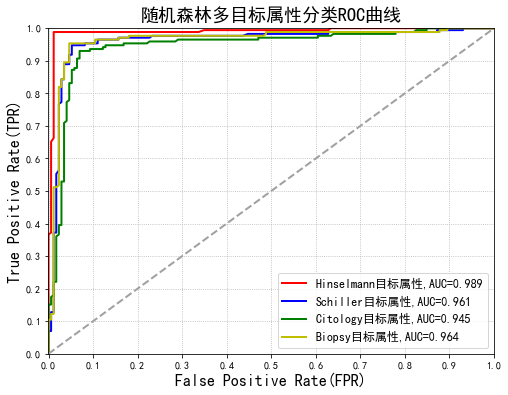

In [63]:
## 8. 画图（ROC图）
plt.figure(figsize=(8, 6), facecolor='w')
plt.plot(forest_fpr1,forest_tpr1,c='r',lw=2,label=u'Hinselmann目标属性,AUC=%.3f' % auc1)
plt.plot(forest_fpr2,forest_tpr2,c='b',lw=2,label=u'Schiller目标属性,AUC=%.3f' % auc2)
plt.plot(forest_fpr3,forest_tpr3,c='g',lw=2,label=u'Citology目标属性,AUC=%.3f' % auc3)
plt.plot(forest_fpr4,forest_tpr4,c='y',lw=2,label=u'Biopsy目标属性,AUC=%.3f' % auc4)
plt.plot((0,1),(0,1),c='#a0a0a0',lw=2,ls='--')
plt.xlim(-0.001, 1.001)
plt.ylim(-0.001, 1.001)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate(FPR)', fontsize=16)
plt.ylabel('True Positive Rate(TPR)', fontsize=16)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title(u'随机森林多目标属性分类ROC曲线', fontsize=18)
plt.show()